In [2]:
import torch
from torch import nn
from torch.nn import functional
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import utils
from model import unet,unet_backbone

In [3]:
voc_dir = '../autodl-tmp/data/VOCdevkit/VOC2012'
# train_features, train_labels = utils.read_voc_images(voc_dir)

In [4]:
crop_size = (320, 480)
voc_train = utils.VOCSegDataset(True, crop_size, voc_dir)
voc_test = utils.VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [9]:
batch_size = 32
train_iter = DataLoader(voc_train, batch_size, shuffle=True)
test_iter = DataLoader(voc_test,batch_size,shuffle=False)
# for X, Y in train_iter:
#     print(X.shape[0])

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
channels = 32 
classes = 21 # 21 classes
input_channels = 3
model = unet.Unet(input_channels,channels,classes).to(device)
model.apply(utils.init_weights)
# print(model)

Unet(
  (cblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3)

In [12]:
lr = 1e-4
# loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-3)
# optimizer = torch.optim.SGD(model.parameters(),lr=lr,weight_decay=1e-3)

In [13]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    utils.train(train_iter, device, model, loss_fn, optimizer)
    utils.test(test_iter,device,model,loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.362349  [    0/ 1114]
loss: 1.801591  [  960/ 1114]
Test Error: 
 Accuracy: 72.66%, Avg loss: 1.698166 

Epoch 2
-------------------------------
loss: 1.944913  [    0/ 1114]
loss: 1.761436  [  960/ 1114]
Test Error: 
 Accuracy: 72.81%, Avg loss: 1.524743 

Epoch 3
-------------------------------
loss: 1.480134  [    0/ 1114]
loss: 1.477250  [  960/ 1114]
Test Error: 
 Accuracy: 72.85%, Avg loss: 1.468307 

Epoch 4
-------------------------------
loss: 1.627256  [    0/ 1114]
loss: 1.373705  [  960/ 1114]
Test Error: 
 Accuracy: 72.85%, Avg loss: 1.390347 

Epoch 5
-------------------------------
loss: 1.225448  [    0/ 1114]
loss: 1.243577  [  960/ 1114]
Test Error: 
 Accuracy: 72.88%, Avg loss: 1.347281 

Epoch 6
-------------------------------
loss: 1.347867  [    0/ 1114]
loss: 1.396402  [  960/ 1114]
Test Error: 
 Accuracy: 72.90%, Avg loss: 1.321902 

Epoch 7
-------------------------------
loss: 1.573440  [    0/ 1114]
loss: 1.2646

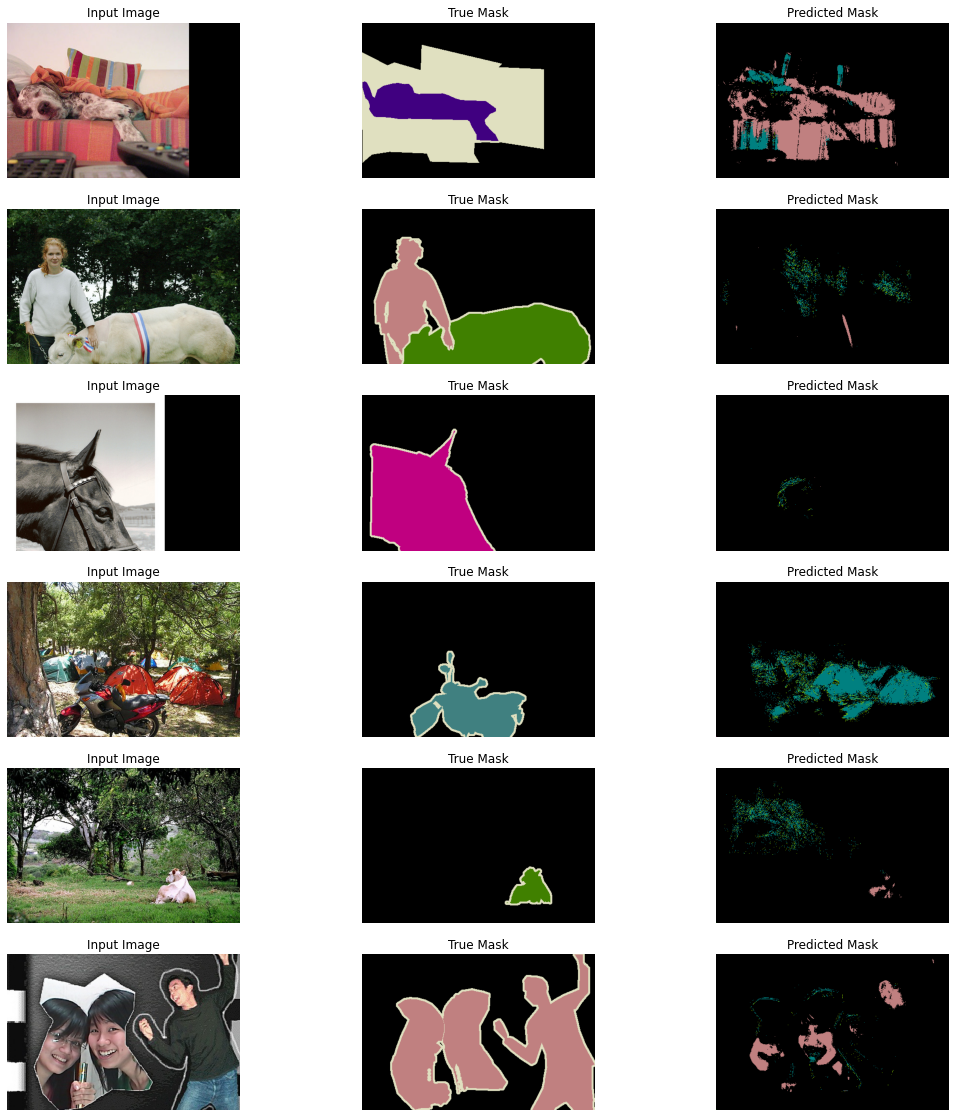

In [15]:
# 裁剪一些图片的一部分进行预测
test_images, test_labels = utils.read_voc_images(voc_dir, False)
n = 6
rows,cols = n,3
title = ['Input Image', 'True Mask', 'Predicted Mask']
plt.figure(figsize=(18, 20))
for i in range(n):
    idx = torch.randint(len(test_images),(1,)).item()
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[idx], *crop_rect)
    pred = utils.label2image(utils.predict(X,test_iter,device,model),device)
    img_list = [X.permute(1,2,0),
                torchvision.transforms.functional.crop(test_labels[idx],*crop_rect).permute(1,2,0),
                pred.cpu()]
    for j,img in enumerate(img_list):
        plt.subplot(rows,cols,i*cols+j+1)
        plt.title(title[j])
        # plt.imshow(transforms.ToPILImage()(img))
        plt.imshow(img.numpy())
        plt.axis('off')
plt.show()

In [17]:
torch.save(model,'Unet-50epochs.pt')